In [1]:
import pandas as pd
from dataprep.eda import plot, plot_correlation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

NumExpr defaulting to 4 threads.


In [2]:
patient = pd.read_csv("mimic/PATIENTS.csv")
admission = pd.read_csv("mimic/ADMISSIONS.csv")
diagnoses_d = pd.read_csv("mimic/D_ICD_DIAGNOSES.csv")
diagnoses = pd.read_csv("mimic/DIAGNOSES_ICD.csv")
icu = pd.read_csv("mimic/ICUSTAYS.csv")
services = pd.read_csv('mimic/SERVICES.csv')

In [3]:
# Assign diagnoses groups according to ICD9_CODE
def assign_category(icd9_code):
    try:
        code = int(icd9_code)
        if code >= 10000:
            code = code // 100
        elif code >= 1000:
            code = code // 10
        else:
            pass
        if code <= 139:
            return 0
        if code <= 239:
            return 1
        if code <= 279:
            return 2
        if code <= 289:
            return 3
        if code <= 319:
            return 4
        if code <= 389:
            return 5
        if code <= 459:
            return 6
        if code <= 519:
            return 7
        if code <= 579:
            return 8
        if code <= 629:
            return 9
        if code <= 679:
            return 10
        if code <= 709:
            return 11
        if code <= 739:
            return 12
        if code <= 759:
            return 13
        if code <= 779:
            return 14
        if code <= 799:
            return 15
        return 16
    except:
        return 17

def calculate_age(df, cur_time, dob):
    df[cur_time] = pd.to_datetime(df[cur_time])
    df[dob] = pd.to_datetime(df[dob])
    result = df[cur_time].dt.year - df[dob].dt.year
    result.loc[result>=300] = 90
    return result

def process_date(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col])
    return df

D_Category = {
    0: 'infectious and parasitic diseases',
    1: 'neoplasms',
    2: 'endocrine, nutritional and metabolic diseases, and immunity disorders',
    3: 'diseases of the blood and blood-forming organs',
    4: 'mental disorders',
    5: 'diseases of the nervous system and sense organs',
    6: 'diseases of the circulatory system',
    7: 'diseases of the respiratory system',
    8: 'diseases of the digestive system',
    9: 'diseases of the genitourinary system',
    10: 'complications of pregnancy, childbirth, and the puerperium',
    11: 'diseases of the skin and subcutaneous tissue',
    12: 'diseases of the musculoskeletal system and connective tissue',
    13: 'congenital anomalies',
    14: 'certain conditions originating in the perinatal period',
    15: 'symptoms, signs, and ill-defined conditions',
    16: ' injury and poisoning',
    17: 'external causes of injury and supplemental classification'
}



In [20]:
diagnoses['category'] = diagnoses['ICD9_CODE'].apply(lambda x: D_Category[assign_category(x)])
admission_patient = admission.merge(patient, on='SUBJECT_ID')
admission_patient['age'] = calculate_age(admission_patient, 'ADMITTIME', 'DOB')
adm_icu_p = admission_patient.merge(icu, on='HADM_ID')
adm_icu_p = adm_icu_p[['HADM_ID', 'age', 'GENDER', 'LOS', 'ADMISSION_TYPE', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'HOSPITAL_EXPIRE_FLAG']]


In [5]:
plot(adm_icu_p[['HOSPITAL_EXPIRE_FLAG']])

GridBox(id='1040', ...)

# 1. Age & Gender

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


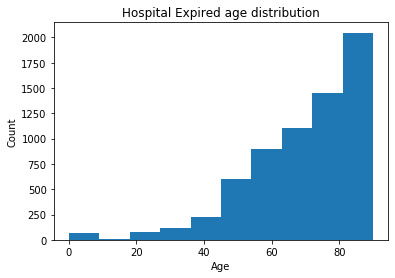

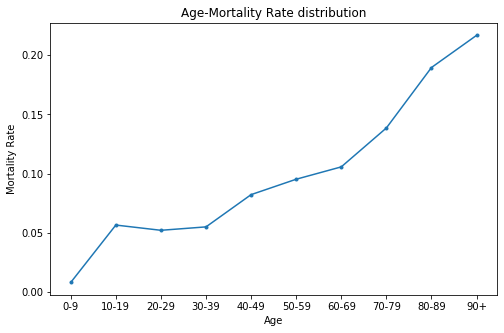

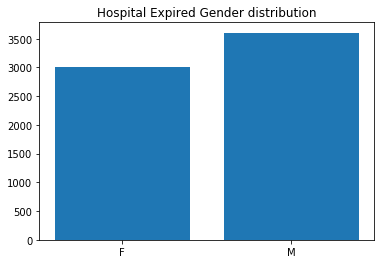

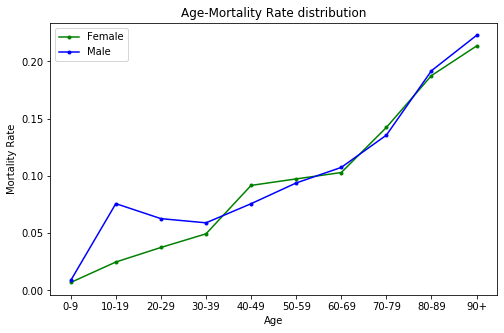

In [68]:
# Expired age distribution
exp = adm_icu_p[adm_icu_p['HOSPITAL_EXPIRE_FLAG']==1]
total = adm_icu_p.copy()
fig1, ax1 = plt.subplots()
ax1.hist(exp['age'], bins=10)
ax1.set(xlabel='Age', ylabel='Count')
ax1.set_title('Hospital Expired age distribution')

bins = pd.IntervalIndex.from_tuples(
    [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90), (90, 100)], 
    closed='left')
exp['age'] = pd.cut(exp['age'], bins)
total['age'] = pd.cut(total['age'], bins)
exp_count = exp.groupby('age').size().rename('count').reset_index()
total_count = total.groupby('age').size().rename('count').reset_index()
proportion = exp_count['count']/total_count['count']


fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.plot(['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+'], proportion.tolist(), '.-')
ax2.set(xlabel='Age', ylabel='Mortality Rate', title='Age-Mortality Rate distribution')

exp_g = exp.groupby('GENDER').size().rename('count').reset_index()
fig3, ax3 = plt.subplots()
ax3.bar(exp_g['GENDER'], exp_g['count'])
ax3.set_title('Hospital Expired Gender distribution')

f = exp[exp['GENDER']=='F'].groupby('age').size().rename('count').reset_index()
m = exp[exp['GENDER']=='M'].groupby('age').size().rename('count').reset_index()
tf = total[total['GENDER']=='F'].groupby('age').size().rename('count').reset_index()
tm = total[total['GENDER']=='M'].groupby('age').size().rename('count').reset_index()
pf = f['count']/tf['count']
pm = m['count']/tm['count']
fig4, ax4 = plt.subplots(figsize=(8, 5))
AGE_RANGE = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
p1 = ax4.plot(AGE_RANGE, pf, '.-', color='green')
p2 = ax4.plot(AGE_RANGE, pm, '.-', color='blue')
ax4.set(title='Age-Mortality Rate distribution', xlabel='Age', ylabel='Mortality Rate')
ax4.legend((p1[0], p2[0]), ('Female', 'Male'))

plt.show();

# 2. Admission Type

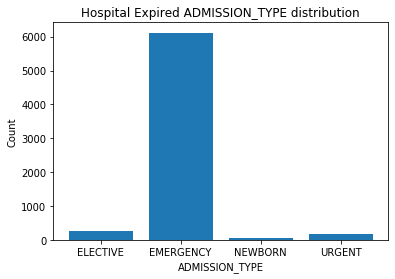

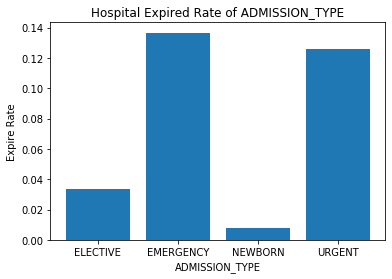

In [54]:
fig1, ax1 = plt.subplots()
data = exp.groupby('ADMISSION_TYPE').size().rename('count').reset_index()
ax1.bar(data['ADMISSION_TYPE'], data['count'])
ax1.set(xlabel='ADMISSION_TYPE', ylabel='Count')
ax1.set_title('Hospital Expired ADMISSION_TYPE distribution')

data_t = total.groupby('ADMISSION_TYPE').size().rename('count').reset_index()
fig2, ax2 = plt.subplots()
ax2.bar(data['ADMISSION_TYPE'], data['count']/data_t['count'])
ax2.set(xlabel='ADMISSION_TYPE', ylabel='Expire Rate')
ax2.set_title('Hospital Expired Rate of ADMISSION_TYPE')

plt.show();

# 3. ICU Type

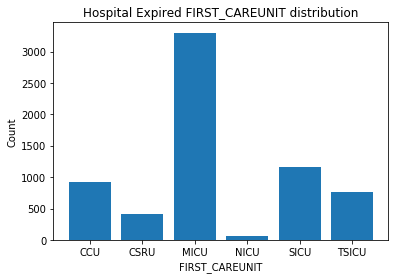

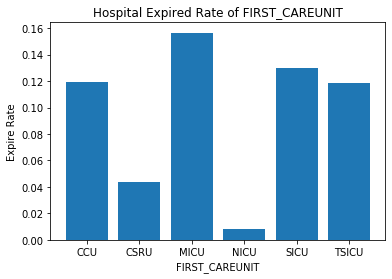

In [55]:
fig1, ax1 = plt.subplots()
data = exp.groupby('FIRST_CAREUNIT').size().rename('count').reset_index()
ax1.bar(data['FIRST_CAREUNIT'], data['count'])
ax1.set(xlabel='FIRST_CAREUNIT', ylabel='Count')
ax1.set_title('Hospital Expired FIRST_CAREUNIT distribution')

data_t = total.groupby('FIRST_CAREUNIT').size().rename('count').reset_index()
fig2, ax2 = plt.subplots()
ax2.bar(data['FIRST_CAREUNIT'], data['count']/data_t['count'])
ax2.set(xlabel='FIRST_CAREUNIT', ylabel='Expire Rate')
ax2.set_title('Hospital Expired Rate of FIRST_CAREUNIT')

plt.show();

# 4. Diagnosis

In [80]:
plot(exp[['DIAGNOSIS']])

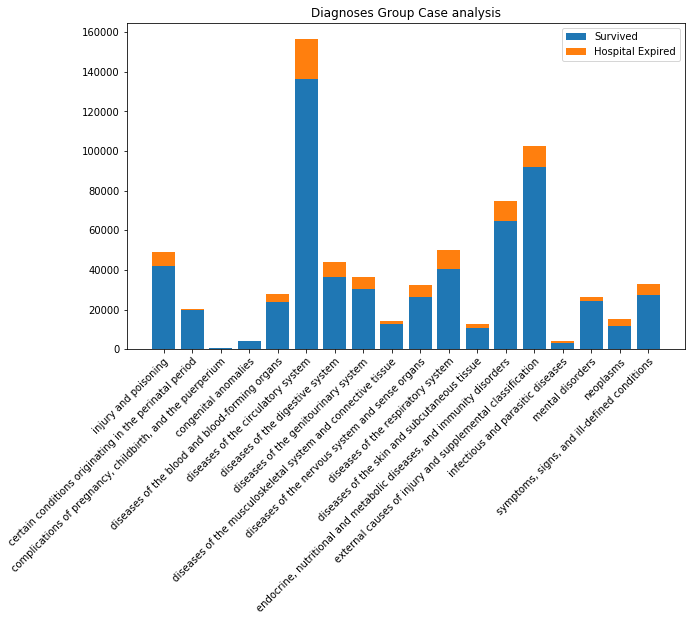

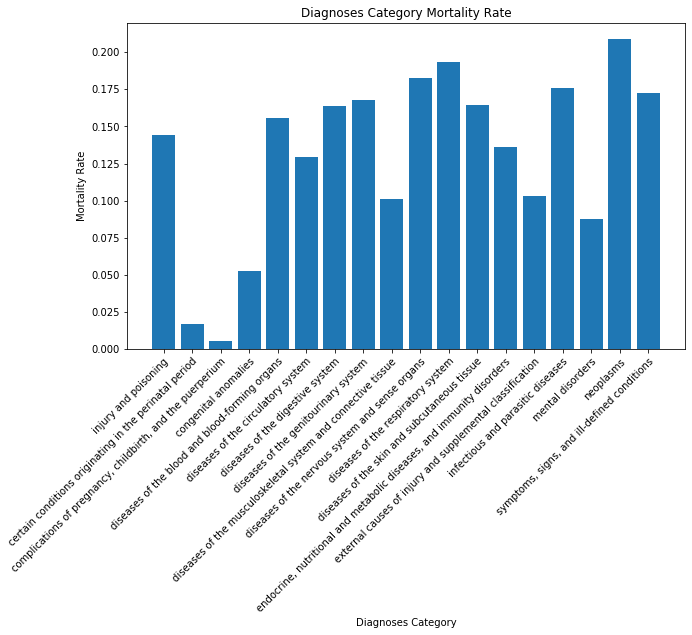

In [83]:
exp_d = exp.merge(diagnoses, on='HADM_ID')
surv = total[total['HOSPITAL_EXPIRE_FLAG']==0]
surv_d = surv.merge(diagnoses, on='HADM_ID')
surv_d = surv_d.groupby('category').size().rename('count').reset_index()
exp_d = exp_d.groupby('category').size().rename('count').reset_index()
total_d = total.merge(diagnoses, on='HADM_ID')
total_d = total_d.groupby('category').size().rename('count').reset_index()

fig, ax = plt.subplots()
p1 = ax.bar(surv_d['category'], surv_d['count'])
p2 = ax.bar(exp_d['category'], exp_d['count'], bottom=surv_d['count'])
ax.legend((p1[0], p2[0]), ('Survived', 'Hospital Expired'))
ax.set_title('Diagnoses Group Case analysis')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fig.set_size_inches(10, 6, forward=True)

fig2, ax2 = plt.subplots()
ax2.bar(exp_d['category'], exp_d['count']/total_d['count'])
ax2.set(xlabel='Diagnoses Category', ylabel='Mortality Rate', title='Diagnoses Category Mortality Rate')
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fig2.set_size_inches(10, 6, forward=True)

plt.show();

# 5. Service

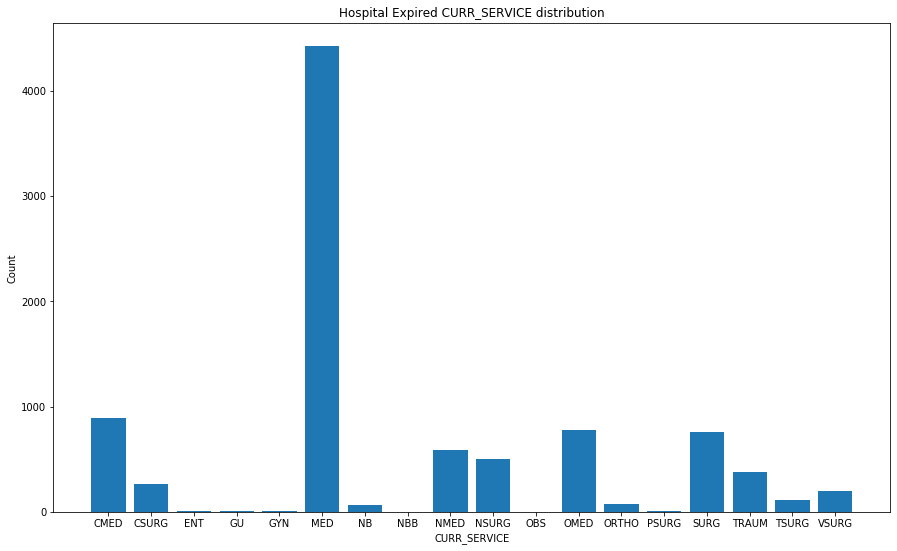

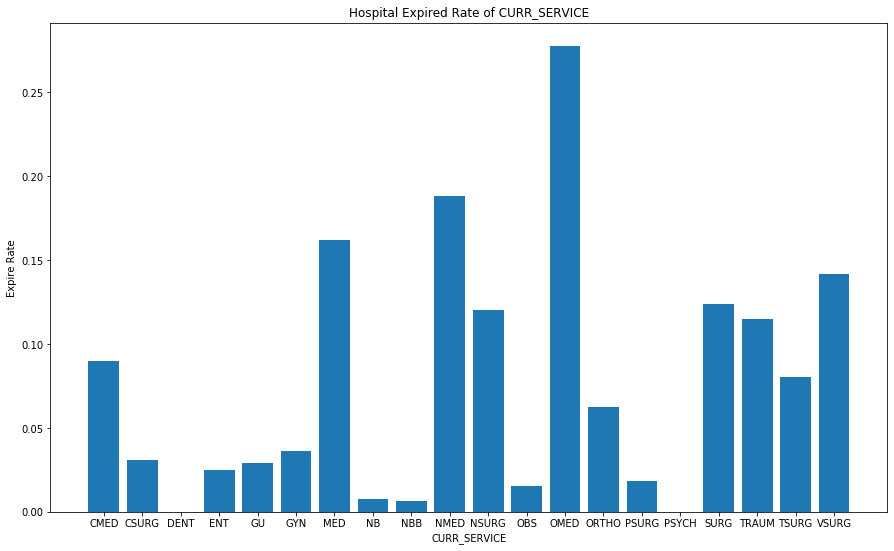

In [95]:
exp_s = exp.merge(services, on='HADM_ID')
fig1, ax1 = plt.subplots(figsize=(15, 9))
data = exp_s.groupby('CURR_SERVICE').size().rename('count').reset_index()
ax1.bar(data['CURR_SERVICE'], data['count'])
ax1.set(xlabel='CURR_SERVICE', ylabel='Count')
ax1.set_title('Hospital Expired CURR_SERVICE distribution')

total_s = total.merge(services, on='HADM_ID')

data_t = total_s.groupby('CURR_SERVICE').size().rename('count').reset_index()

fig2, ax2 = plt.subplots(figsize=(15, 9))
data = data_t.merge(data, on='CURR_SERVICE', how='left')
data = data.fillna(0)

ax2.bar(data['CURR_SERVICE'], data['count_y']/data['count_x'])
ax2.set(xlabel='CURR_SERVICE', ylabel='Expire Rate')
ax2.set_title('Hospital Expired Rate of CURR_SERVICE')

plt.show();


# LOS

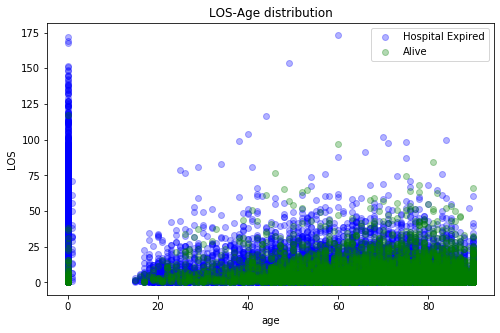

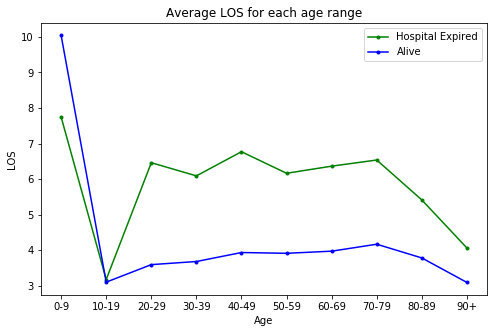

In [70]:
# LOS - Mortality
dead = adm_icu_p[adm_icu_p['HOSPITAL_EXPIRE_FLAG']==1]
alive = adm_icu_p[adm_icu_p['HOSPITAL_EXPIRE_FLAG']==0]


f1, a1 = plt.subplots(figsize=(8, 5))
p1 = a1.plot(alive['age'], alive['LOS'], 'o', color='blue', alpha=0.3)
p2 = a1.plot(dead['age'], dead['LOS'], 'o', color='green', alpha=0.3)

a1.legend((p1[0], p2[0]), ('Hospital Expired', 'Alive'))
a1.set(xlabel='age', ylabel='LOS', title='LOS-Age distribution')
# avg LOS
f2, a2 = plt.subplots(figsize=(8, 5))
data1 = exp.groupby('age')['LOS'].mean().rename('mean').reset_index()
data2 = surv.groupby('age')['LOS'].mean().rename('mean').reset_index()
p1 = a2.plot(AGE_RANGE, data1['mean'], '.-', color='green')
p2 = a2.plot(AGE_RANGE, data2['mean'], '.-', color='blue')
a2.set(title='Average LOS for each age range', xlabel='Age', ylabel='LOS')
a2.legend((p1[0], p2[0]), ('Hospital Expired', 'Alive'))

plt.show();